In [1]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-08 05:48:34.055513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

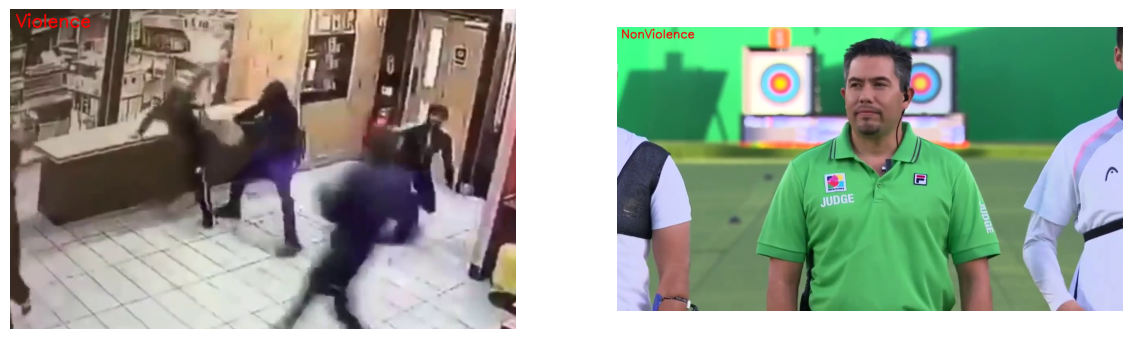

In [5]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
 
# Get Names of all classes in UCF50
all_classes_names = os.listdir('extracted_files')
 
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 2)
 
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
 
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'extracted_files/{selected_class_Name}')
 
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'extracted_files/{selected_class_Name}/{selected_video_file_name}')
     
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
 
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [12]:
image_height, image_width = 64, 64
max_images_per_class = 25
 
dataset_directory = "extracted_files"
classes_list = ["Violence", "NonViolence"]
 
model_output_size = len(classes_list)

In [13]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
     
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
 
    # Iterating through Video Frames
    while True:
 
        # Reading a frame from the video file 
        success, frame = video_reader.read() 
 
        # If Video frame was not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
         
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
         
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
     
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # returning the frames list 
    return frames_list

In [26]:
def create_dataset():
 
    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
     
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
         
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
 
        # Iterating through all the files present in the files list
        for file_name in files_list:
 
            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
 
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)
 
            # Appending the frames to a temporary list.
            temp_features.extend(frames)
         
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))
 
        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
         
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()
 
    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
 
    return features, labels

In [27]:
features, labels = create_dataset()

Extracting Data of Class: Violence


OpenCV: Couldn't read video stream from file "extracted_files/Violence/.DS_Store"
[ERROR:0@1017.242] global cap.cpp:166 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): extracted_files/Violence/.DS_Store in function 'icvExtractPattern'




Extracting Data of Class: NonViolence


OpenCV: Couldn't read video stream from file "extracted_files/NonViolence/.DS_Store"
[ERROR:0@1018.868] global cap.cpp:166 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): extracted_files/NonViolence/.DS_Store in function 'icvExtractPattern'




In [28]:
one_hot_encoded_labels = to_categorical(labels)

In [29]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 'features' is your input data (features)
# 'labels' is your corresponding output data (labels)
# test_size=0.2 specifies that 20% of the data will be used for testing
# random_state=42 sets a seed value for reproducibility

# Verify the shapes of the data splits
print("Training set shapes:")
print("Features:", features_train.shape)
print("Labels:", labels_train.shape)
print("Testing set shapes:")
print("Features:", features_test.shape)
print("Labels:", labels_test.shape)

Training set shapes:
Features: (40, 64, 64, 3)
Labels: (40,)
Testing set shapes:
Features: (10, 64, 64, 3)
Labels: (10,)


In [30]:
#Let's create a function that will construct our model
def create_model():
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))
 
    # Printing the models summary
    model.summary()
 
    return model
 
 # Calling the create_model method
model = create_model()
 
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization_2 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                      

In [31]:
# Adding Early Stopping Callback
from keras.utils import to_categorical

# Convert labels to one-hot encoded format
labels_train_encoded = to_categorical(labels_train)

# Define and compile your model

# Start Training

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start Training
model_training_history = model.fit(x=features_train, y=labels_train_encoded, epochs=15, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/15
8/8 [==============================] - 1s 39ms/step - loss: 0.8556 - accuracy: 0.5938 - val_loss: 0.6914 - val_accuracy: 0.6250
Epoch 2/15
8/8 [==============================] - 0s 26ms/step - loss: 0.5728 - accuracy: 0.7188 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 0s 25ms/step - loss: 0.5119 - accuracy: 0.6562 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 0s 26ms/step - loss: 0.3051 - accuracy: 0.9062 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 5/15
8/8 [==============================] - 0s 26ms/step - loss: 0.3908 - accuracy: 0.8438 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 6/15
8/8 [==============================] - 0s 26ms/step - loss: 0.4340 - accuracy: 0.8125 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 7/15
8/8 [==============================] - 0s 25ms/step - loss: 0.3748 - accuracy: 0.8125 - val_loss: 0.7020 - val_accuracy: 0.5000
Epoch 8/15
8/8 [===========

In [32]:

# Convert labels to one-hot encoded format
labels_test_encoded = to_categorical(labels_test)

# Evaluate the model
model_evaluation_history = model.evaluate(features_test, labels_test_encoded)

#model_evaluation_history = model.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 107ms/step - loss: 0.7701 - accuracy: 0.3000


In [33]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
 
  # Constructing a range object which will be used as time 
    epochs = range(len(metric_value_1))
   
  # Plotting the Graph
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
   
  # Adding title to the plot
    plt.title(str(plot_name))
 
  # Adding legend to the plot
    plt.legend()

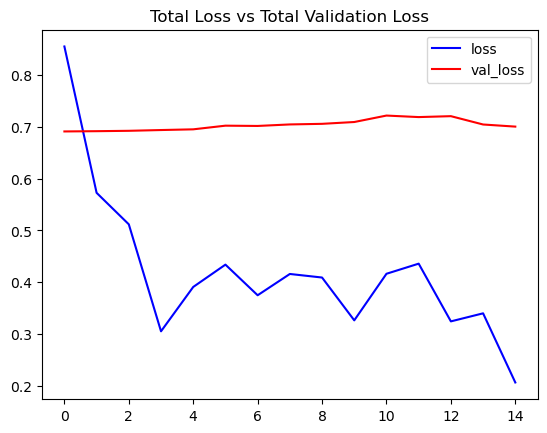

In [34]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

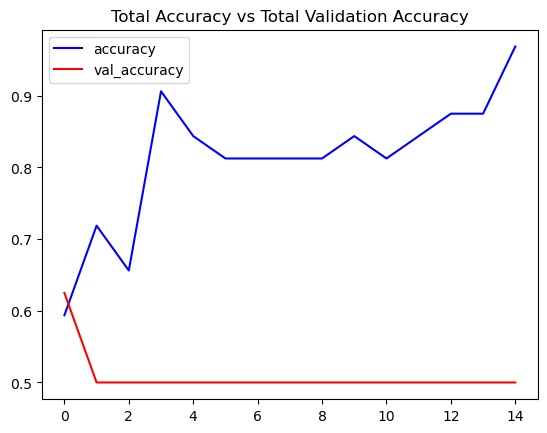

In [35]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')